# **12.1 Cross Validation and Hyperparameter Optimisation XGBRegressor**

## Objectives

* Apply appropriate ML methods (regression/classification/clustering). Evaluate with relevant metrics. Compare approaches
* GradientBoostingRegressor
* Introduce features Easting and Northing and minimum distance to a city centre


## Inputs

* housing_cleaned-geo.csv

## Outputs

* GradientBoostingRegressor_set.csv
* GradientBoostingRegressor_model.pkl


---

# GradientBoostingRegressor model

Import packages

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV


In [83]:
# read in the cleaned data
df = pd.read_csv('../data/clean/housing_cleaned-geo.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 51 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   transaction                   7248 non-null   object 
 1   price                         7248 non-null   float64
 2   transfer_date                 7248 non-null   object 
 3   postcode                      7248 non-null   object 
 4   property_type                 7248 non-null   object 
 5   new_build                     7248 non-null   float64
 6   tenure                        7248 non-null   object 
 7   PAON                          7248 non-null   object 
 8   SAON                          371 non-null    object 
 9   Street                        7219 non-null   object 
 10  Locality                      3020 non-null   object 
 11  town_city                     7248 non-null   object 
 12  district                      7248 non-null   object 
 13  cou

---

The ruc21 values refer to the Rural Urban Classification (RUC) codes which categorize each area as urban or rural based on population and settlement characteristics. Examples from your data include UNI, RUN1, RSNI, UF1, etc.

- UN1: Urban city and town
- RLN1: Rural town and fringe
- RSN1: Rural village
- UF1: Urban major conurbation
- RLF1: Rural hamlet and isolated dwellings
- RSF1: Rural hamlet and isolated dwellings in a sparse setting

In [84]:
df['ruc21'].value_counts()

ruc21
UN1     5888
RLN1     622
RSN1     469
UF1      131
RLF1      70
RSF1      68
Name: count, dtype: int64

In [85]:
# convert to datetime
df['transfer_date'] = pd.to_datetime(df['transfer_date'])
# keep only the transfer_date for 2024 onwards
df = df[df['transfer_date'].dt.year >= 2024]

In [86]:
# set model features
# Calculate Distance nearest to retail shopping centre

# Calculate distance to nearest retail shopping centre
# Using distance in OSGB36 / British National Grid (metres)
# Centre points (OSGB36 / British National Grid, metres)
CENTRES_OSGB = {
    'bhm': (406000, 286000),  # Birmingham city centre
    'cov': (433000, 279000),  # Coventry city centre
    'lei': (458500, 306000),  # Leicester city centre
    'not': (457119, 340206),  # Nottingham (Old Market Sq vicinity)
    'der': (435187, 336492),  # Derby (near Council House)
    'sto': (388468, 347224),  # Stoke-on-Trent (Hanley)
    'wol': (386523, 298603),  # Wolverhampton (Queen Sq)
    'sol': (414438, 279717),  # Solihull (Touchwood area)
}

# distances (km) for each centre and minimum distance
for key, (E0, N0) in CENTRES_OSGB.items():
    df[f'dist_{key}_km'] = np.hypot(df['oseast1m'] - E0, df['osnrth1m'] - N0) / 1000.0
df['min_dist_to_retail_centre_km'] = df[['dist_bhm_km', 'dist_cov_km', 'dist_lei_km', 'dist_not_km', 'dist_der_km', 'dist_sto_km', 'dist_wol_km', 'dist_sol_km']].min(axis=1)
# drop the individual distance columns
df = df.drop(columns=[f'dist_{key}_km' for key in CENTRES_OSGB.keys()])


num_feats   = ['log_total_floor_area','IMD_Rank','oseast1m','osnrth1m','min_dist_to_retail_centre_km','energy_band_num']
bin_feats   = ['new_build','is_leasehold']  # pass through as 0/1
cat_feats   = ['property_type','ruc21']  # one-hot encode

# Control category order to set baselines via drop='first'
ptype_order = ['D','S','T','F']  # baseline becomes 'D' (Detached)
ruc21_order = ['UN1','UF1','RLN1','RSN1','RLF1','RSF1']  # baseline becomes UN1 (Urban city and town)

# Build the ColumnTransformer (code supported by Copilot)
pre = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_feats),
        ('cat', OneHotEncoder(drop='first',
                              categories=[ptype_order,  ruc21_order],
                              handle_unknown='ignore'),
         cat_feats),
        ('bin', 'passthrough', bin_feats),
    ],
    remainder='drop'
 )

# End-to-end pipeline
pipeline = Pipeline([
    ('pre', pre),
    ('model', XGBRegressor(random_state=101))
])

X = df[num_feats + cat_feats + bin_feats]
y = df['log_price']  # log price to reduce skew

# Test using the most recent 20% of the data as the test set
# Use a sorted split based on date
df = df.sort_values(by='transfer_date').reset_index(drop=True)
# split index at 80%
split_index = int(len(df) * 0.8)
print(f"Split index: {split_index}, Total records: {len(df)}")
print(f"Date at split index: {df.iloc[split_index]['transfer_date']}")

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# separate target variable
y_train = train_df['log_price']
y_test = test_df['log_price']
X_train = train_df.drop(columns=['log_price'])
X_test = test_df.drop(columns=['log_price'])

print("* Train set:", X_train.shape, y_train.shape, "\n* Test set:",  X_test.shape, y_test.shape)



Split index: 5667, Total records: 7084
Date at split index: 2025-08-01 00:00:00
* Train set: (5667, 51) (5667,) 
* Test set: (1417, 51) (1417,)
* Train set: (5667, 51) (5667,) 
* Test set: (1417, 51) (1417,)


We will now set the hyperparameters for the XGBoost model: [Documentation](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

In [87]:
param_grid = [{
    'model__n_estimators': [30, 80, 200],
    'model__max_depth': [None, 3, 15],
    'model__learning_rate': [0.01, 0.1, 0.001],
    'model__gamma': [0, 0.1],
}]

In [88]:
grid = GridSearchCV(estimator=pipeline,
                    param_grid=param_grid,
                    cv=3,  # 3-fold cross-validation
                    n_jobs=1,
                    verbose=3,  # print the score from every cross-validation
                    scoring='r2')

In [89]:
# run the grid search
grid.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits



c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=30;, score=-401.622 total time=   0.5s
[CV 2/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=30;, score=-386.598 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=30;, score=-421.758 total time=   0.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=80;, score=-146.927 total time=   0.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=80;, score=-141.548 total time=   0.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=80;, score=-153.968 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=200;, score=-12.641 total time=   0.6s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=200;, score=-12.299 total time=   0.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=200;, score=-13.253 total time=   0.4s
[CV 1/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=30;, score=-401.622 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=30;, score=-386.598 total time=   0.0s
[CV 3/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=30;, score=-421.758 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=80;, score=-146.927 total time=   0.1s
[CV 2/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=80;, score=-141.548 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` ins

[CV 3/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=80;, score=-153.968 total time=   0.1s
[CV 1/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200;, score=-12.675 total time=   0.3s
[CV 1/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200;, score=-12.675 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200;, score=-12.302 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200;, score=-13.226 total time=   0.3s
[CV 1/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=30;, score=-401.622 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=30;, score=-386.598 total time=   0.0s
[CV 3/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=30;, score=-421.758 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=80;, score=-146.927 total time=   0.1s
[CV 2/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=80;, score=-141.548 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=80;, score=-153.968 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=200;, score=-12.640 total time=   0.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=200;, score=-12.298 total time=   0.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=200;, score=-13.252 total time=   0.4s
[CV 1/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=30;, score=-0.662 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=30;, score=-0.668 total time=   0.0s
[CV 3/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=30;, score=-0.727 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=80;, score=0.714 total time=   0.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=80;, score=0.714 total time=   0.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=80;, score=0.756 total time=   0.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=200;, score=0.712 total time=   0.6s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=200;, score=0.712 total time=   0.7s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=200;, score=0.754 total time=   0.7s
[CV 1/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=30;, score=-0.702 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=30;, score=-0.694 total time=   0.0s
[CV 3/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=30;, score=-0.712 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=80;, score=0.703 total time=   0.7s
[CV 2/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=80;, score=0.703 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=80;, score=0.749 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200;, score=0.716 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200;, score=0.716 total time=   0.7s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200;, score=0.764 total time=   1.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=30;, score=-0.674 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=30;, score=-0.682 total time=   0.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=30;, score=-0.752 total time=   4.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=80;, score=0.693 total time=   1.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=80;, score=0.695 total time=   2.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=80;, score=0.731 total time=   6.6s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=200;, score=0.686 total time=   4.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=200;, score=0.694 total time=   2.6s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=200;, score=0.725 total time=   2.3s
[CV 1/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=30;, score=-691.250 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=30;, score=-665.077 total time=   0.0s
[CV 3/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=30;, score=-726.345 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=80;, score=-625.446 total time=   1.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=80;, score=-601.810 total time=   0.3s
[CV 3/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=80;, score=-657.135 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=200;, score=-491.933 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=200;, score=-473.451 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=200;, score=-516.728 total time=   0.3s
[CV 1/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=30;, score=-691.250 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=30;, score=-665.077 total time=   0.1s
[CV 3/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=30;, score=-726.345 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=80;, score=-625.446 total time=   0.1s
[CV 2/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=80;, score=-601.810 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=80;, score=-657.135 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=200;, score=-491.933 total time=   0.5s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=200;, score=-473.451 total time=   0.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=200;, score=-516.728 total time=   0.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=30;, score=-691.250 total time=   0.9s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=30;, score=-665.077 total time=   0.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=30;, score=-726.345 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=80;, score=-625.446 total time=   0.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=80;, score=-601.810 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=80;, score=-657.135 total time=   0.5s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=200;, score=-491.933 total time=   0.7s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=200;, score=-473.451 total time=   0.5s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=200;, score=-516.728 total time=   0.8s
[CV 1/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=30;, score=-401.622 total time=   0.0s
[CV 2/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=30;, score=-386.598 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=30;, score=-421.758 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=80;, score=-146.927 total time=   0.1s
[CV 2/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=80;, score=-141.548 total time=   0.2s
[CV 2/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=80;, score=-141.548 total time=   0.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=80;, score=-153.968 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=200;, score=-12.640 total time=   0.5s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=200;, score=-12.297 total time=   0.7s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=None, model__n_estimators=200;, score=-13.249 total time=   0.4s
[CV 1/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=30;, score=-401.622 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=30;, score=-386.598 total time=   0.0s
[CV 3/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=30;, score=-421.758 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=80;, score=-146.927 total time=   0.1s
[CV 2/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=80;, score=-141.548 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` ins

[CV 3/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=80;, score=-153.968 total time=   0.1s
[CV 1/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200;, score=-12.677 total time=   0.4s
[CV 1/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200;, score=-12.677 total time=   0.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200;, score=-12.301 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=3, model__n_estimators=200;, score=-13.225 total time=   1.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=30;, score=-401.622 total time=   0.2s
[CV 2/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=30;, score=-386.598 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=30;, score=-421.758 total time=   0.0s
[CV 1/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=80;, score=-146.927 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=80;, score=-141.548 total time=   0.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=80;, score=-153.968 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=200;, score=-12.640 total time=   1.5s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=200;, score=-12.295 total time=   0.5s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.01, model__max_depth=15, model__n_estimators=200;, score=-13.250 total time=   0.6s
[CV 1/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=30;, score=-0.651 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=30;, score=-0.672 total time=   0.1s
[CV 3/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=30;, score=-0.731 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=80;, score=0.717 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=80;, score=0.717 total time=   1.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=80;, score=0.759 total time=   0.5s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=200;, score=0.721 total time=   0.7s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=200;, score=0.718 total time=   0.7s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=None, model__n_estimators=200;, score=0.760 total time=   0.9s
[CV 1/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=30;, score=-0.697 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=30;, score=-0.695 total time=   0.3s
[CV 3/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=30;, score=-0.725 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=80;, score=0.702 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=80;, score=0.704 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=80;, score=0.748 total time=   0.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200;, score=0.718 total time=   0.8s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200;, score=0.715 total time=   0.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=3, model__n_estimators=200;, score=0.762 total time=   0.5s
[CV 1/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=30;, score=-0.662 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=30;, score=-0.672 total time=   0.8s
[CV 3/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=30;, score=-0.745 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=80;, score=0.716 total time=   0.7s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=80;, score=0.709 total time=   0.8s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=80;, score=0.747 total time=   1.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=200;, score=0.715 total time=   3.9s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=200;, score=0.709 total time=   1.9s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.1, model__max_depth=15, model__n_estimators=200;, score=0.747 total time=   3.5s
[CV 1/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=30;, score=-691.250 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=30;, score=-665.077 total time=   0.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=30;, score=-726.345 total time=   0.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=80;, score=-625.446 total time=   0.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=80;, score=-601.810 total time=   0.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=80;, score=-657.135 total time=   0.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=200;, score=-491.933 total time=   0.6s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=200;, score=-473.451 total time=   0.7s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=None, model__n_estimators=200;, score=-516.728 total time=   2.7s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=30;, score=-691.250 total time=   1.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=30;, score=-665.077 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=30;, score=-726.345 total time=   0.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=80;, score=-625.446 total time=   2.7s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=80;, score=-601.810 total time=   0.8s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=80;, score=-657.135 total time=   3.5s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=200;, score=-491.933 total time=   0.8s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=200;, score=-473.451 total time=   4.4s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=3, model__n_estimators=200;, score=-516.728 total time=   1.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=30;, score=-691.250 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=30;, score=-665.077 total time=   0.2s
[CV 3/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=30;, score=-726.345 total time=   0.1s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=80;, score=-625.446 total time=   0.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=80;, score=-601.810 total time=   0.2s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=80;, score=-657.135 total time=   0.6s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 1/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=200;, score=-491.933 total time=   1.0s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 2/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=200;, score=-473.451 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


[CV 3/3] END model__gamma=0.1, model__learning_rate=0.001, model__max_depth=15, model__n_estimators=200;, score=-516.728 total time=   0.3s


c:\Users\marka\Midlands_House_Prices\Midlands_House_Prices\.venv\Lib\site-packages\xgboost\data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pre',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['log_total_floor_area',
                                                                          'IMD_Rank',
                                                                          'oseast1m',
                                                                          'osnrth1m',
                                                                          'min_dist_to_retail_centre_km',
                                                                          'energy_band_num']),
                                                                        ('cat',
                                                                         OneHotEncoder(categories=[['D',
                                                                                                    'S',
                                                                                                    'T',
                                                                                                    'F'],
                                                                                                   ['UN1',
                                                                                                    'UF1',
                                                                                                    'RLN1',
                                                                                                    'RSN1',
                                                                                                    'RLF1',
                                                                                                    'RSF1']],
                                                                                       drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['p...
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=101, ...))]),
             n_jobs=1,
             param_grid=[{'model__gamma': [0, 0.1],
                          'model__learning_rate': [0.01, 0.1, 0.001],
                          'model__max_depth': [None, 3, 15],
                          'model__n_estimators': [30, 80, 200]}],
             scoring='r2', verbose=3)

In [90]:
grid.cv_results_

{'mean_fit_time': array([0.37328863, 0.2988739 , 0.56506848, 0.08353313, 0.17585071,
        0.3899974 , 0.08987093, 0.1478316 , 0.46619773, 0.10422214,
        0.27845915, 0.7469612 , 0.09950312, 0.39436165, 0.84351373,
        1.57220276, 3.4823974 , 3.09287167, 0.09845058, 0.50827734,
        0.3604629 , 0.1523068 , 0.22784901, 0.49311558, 0.46596686,
        0.46806836, 0.68589838, 0.08385531, 0.23111645, 0.62219731,
        0.10381707, 0.16250491, 0.7282331 , 0.14450471, 0.22184436,
        0.96799827, 0.1331509 , 0.69027336, 0.85332473, 0.22274836,
        0.39075851, 0.64097206, 0.40409295, 1.03724662, 3.17537196,
        0.22598545, 0.30822341, 1.36483177, 0.64641968, 2.42024867,
        2.12306213, 0.18190932, 0.29659939, 0.60941219]),
 'std_fit_time': array([0.1649891 , 0.0408656 , 0.09565469, 0.00481798, 0.00728436,
        0.02482672, 0.01068241, 0.01049358, 0.02125808, 0.00680702,
        0.02254435, 0.06303844, 0.01208229, 0.26585922, 0.37277044,
        1.9185695 , 2.281

In [91]:
(pd.DataFrame(grid.cv_results_)
.sort_values(by='mean_test_score',ascending=False)
.filter(['params','mean_test_score'])
.values
 )

array([[{'model__gamma': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': None, 'model__n_estimators': 200},
        0.7329778214071959],
       [{'model__gamma': 0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200},
        0.7320836330696068],
       [{'model__gamma': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 200},
        0.731788202368736],
       [{'model__gamma': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': None, 'model__n_estimators': 80},
        0.7307606156993548],
       [{'model__gamma': 0, 'model__learning_rate': 0.1, 'model__max_depth': None, 'model__n_estimators': 80},
        0.7278082446119786],
       [{'model__gamma': 0, 'model__learning_rate': 0.1, 'model__max_depth': None, 'model__n_estimators': 200},
        0.7257985901751031],
       [{'model__gamma': 0.1, 'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__n_estimators': 200},
        0.7239317110623436],
       [{'model_

In [92]:
grid.best_params_

{'model__gamma': 0.1,
 'model__learning_rate': 0.1,
 'model__max_depth': None,
 'model__n_estimators': 200}

In [93]:
pipeline = grid.best_estimator_
pipeline

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['log_total_floor_area',
                                                   'IMD_Rank', 'oseast1m',
                                                   'osnrth1m',
                                                   'min_dist_to_retail_centre_km',
                                                   'energy_band_num']),
                                                 ('cat',
                                                  OneHotEncoder(categories=[['D',
                                                                             'S',
                                                                             'T',
                                                                             'F'],
                                                                            ['UN1',
                                                                             'UF1',
                                                                             'RLN1',
                                                                             'RSN1',
                                                                             'RLF1',
                                                                             'RSF1']],
                                                                drop='first',
                                                                handle_unknown='ignore'),
                                                  ['property_type', 'ruc21']),
                                                 ('bi...
                              feature_types=None, gamma=0.1, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=200,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=101, ...))])

### Note:
- The following feature_importance_tree_based_models custom function was provided by the Code Institute for their Data Analysis with AI course.

In [94]:
def feature_importance_tree_based_models(model, columns):
  """
  Gets the model and the columns used to train the model
  - We use the model.feature_importances_ and columns to make a
  DataFrame that shows the importance of each feature
  - Next, we print the feature name and its relative importance order,
  followed by a barplot indicating the importance

  """

  # create DataFrame to display feature importance
  df_feature_importance = (pd.DataFrame(data={
      'Features': columns,
      'Importance': model.feature_importances_})
  .sort_values(by='Importance', ascending=False)
  )

  best_features = df_feature_importance['Features'].to_list()

  # Most important features statement and plot
  print(f"* These are the {len(best_features)} most important features in descending order. "
        f"The model was trained on them: \n{df_feature_importance['Features'].to_list()}")

  df_feature_importance.plot(kind='bar',x='Features',y='Importance')
  plt.show()


def get_feature_names_from_preprocessor(preprocessor):
    """Return feature names for each transformer within a fitted ColumnTransformer."""
    feature_names = []
    for name, transformer, columns in preprocessor.transformers_:
        if name == 'remainder' or transformer == 'drop':
            continue
        if transformer == 'passthrough':
            feature_names.extend(columns)
            continue
        fitted_transformer = transformer
        # Pipelines expose the final estimator through steps[-1]
        if hasattr(transformer, 'steps') and len(transformer.steps) > 0:
            fitted_transformer = transformer.steps[-1][1]
        if hasattr(fitted_transformer, 'get_feature_names_out'):
            try:
                names = fitted_transformer.get_feature_names_out(columns)
            except TypeError:
                names = fitted_transformer.get_feature_names_out()
        else:
            names = columns
        feature_names.extend(list(names))
    return feature_names

* These are the 16 most important features in descending order. The model was trained on them: 
['log_total_floor_area', 'property_type_S', 'property_type_F', 'property_type_T', 'ruc21_RSN1', 'IMD_Rank', 'new_build', 'ruc21_RSF1', 'osnrth1m', 'oseast1m', 'energy_band_num', 'min_dist_to_retail_centre_km', 'ruc21_UF1', 'ruc21_RLN1', 'ruc21_RLF1', 'is_leasehold']


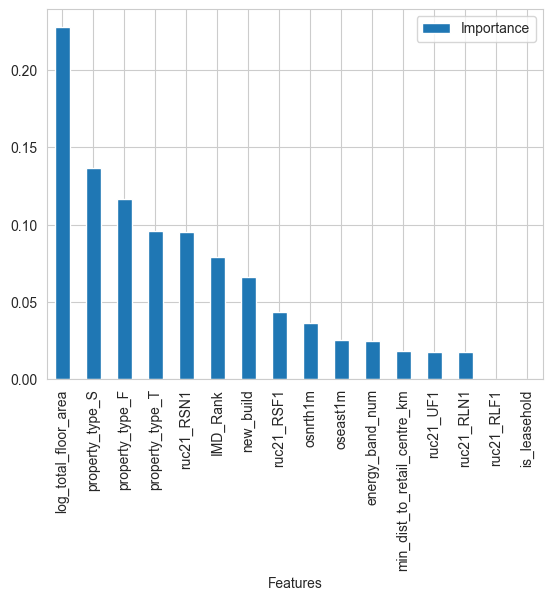

In [95]:
feature_names = get_feature_names_from_preprocessor(pipeline['pre'])
feature_importance_tree_based_models(model=pipeline['model'],
                                     columns=feature_names)

# Evaluate the model

In [96]:
# import regression metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
# we will use numpy to calculate RMSE based on MSE (mean_squared_error)
import numpy as np


def regression_performance(X_train, y_train, X_test, y_test,pipeline):
  """
  # Gets train/test sets and pipeline and evaluates the performance
  - for each set (train and test) call regression_evaluation()
  which will evaluate the pipeline performance
  """

  print("Model Evaluation \n")
  print("* Train Set")
  regression_evaluation(X_train,y_train,pipeline)
  print("* Test Set")
  regression_evaluation(X_test,y_test,pipeline)



def regression_evaluation(X,y,pipeline):
  """
  # Gets features and target (either from train or test set) and pipeline
  - it predicts using the pipeline and the features
  - calculates performance metrics comparing the prediction to the target
  """
  prediction = pipeline.predict(X)
  print('R2 Score:', r2_score(y, prediction).round(3))  
  print('Mean Absolute Error:', mean_absolute_error(y, prediction).round(3))  
  print('Mean Squared Error:', mean_squared_error(y, prediction).round(3))  
  print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y, prediction)).round(3))
  print("\n")

  

def regression_evaluation_plots(X_train, y_train, X_test, y_test,pipeline, alpha_scatter=0.5):
  """
  # Gets Train and Test set (features and target), pipeline, and adjust dots transparency 
  at scatter plot
  - It predicts on train and test set
  - It creates Actual vs Prediction scatterplots, for train and test set
  - It draws a red diagonal line. In theory, a good regressor should predict
  close to the actual, meaning the dot should be close to the diagonal red line
  The closer the dots are to the line, the better

  """
  pred_train = pipeline.predict(X_train)
  pred_test = pipeline.predict(X_test)


  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
  sns.scatterplot(x=y_train , y=pred_train, alpha=alpha_scatter, ax=axes[0])
  sns.lineplot(x=y_train , y=y_train, color='red', ax=axes[0])
  axes[0].set_xlabel("Actual")
  axes[0].set_ylabel("Predictions")
  axes[0].set_title("Train Set")

  sns.scatterplot(x=y_test , y=pred_test, alpha=alpha_scatter, ax=axes[1])
  sns.lineplot(x=y_test , y=y_test, color='red', ax=axes[1])
  axes[1].set_xlabel("Actual")
  axes[1].set_ylabel("Predictions")
  axes[1].set_title("Test Set")

  plt.show()

Model Evaluation 

* Train Set
R2 Score: 0.855
Mean Absolute Error: 0.124
Mean Squared Error: 0.028
Root Mean Squared Error: 0.168


* Test Set
R2 Score: 0.786
Mean Absolute Error: 0.157
Mean Squared Error: 0.045
Root Mean Squared Error: 0.213


R2 Score: 0.786
Mean Absolute Error: 0.157
Mean Squared Error: 0.045
Root Mean Squared Error: 0.213




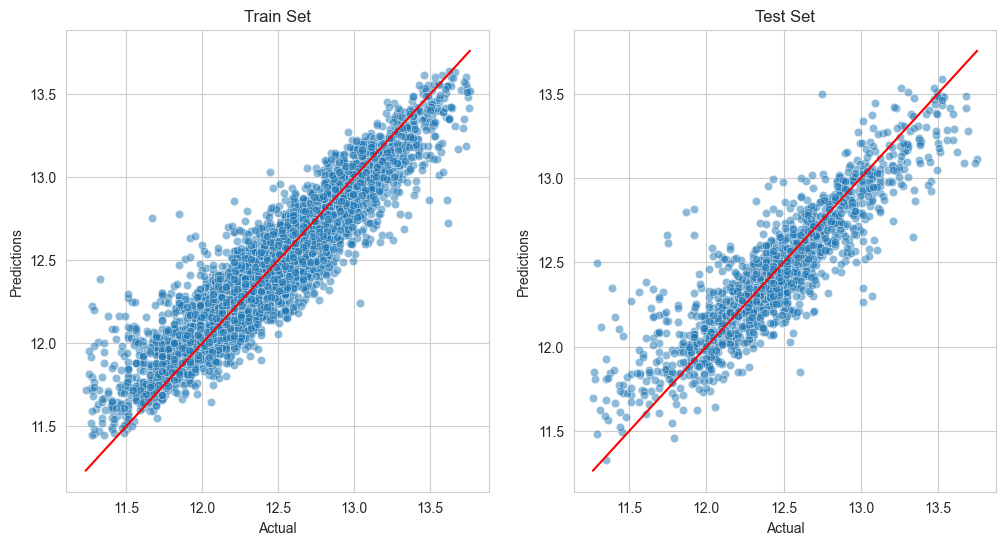

In [97]:
regression_performance(X_train, y_train, X_test, y_test, pipeline)
regression_evaluation_plots(X_train, y_train, X_test, y_test, 
                            pipeline, alpha_scatter=0.5)

In [98]:
# change the actuals and predictions to GBP
y_train_gbp = np.expm1(y_train)
y_test_gbp = np.expm1(y_test)
y_pred_gbp = np.expm1(pipeline.predict(X_test))
y_pred_train = np.expm1(pipeline.predict(X_train))

# calculate MAE and MSE should be in GBP not log(GBP) 
mae_train = mean_absolute_error(y_train_gbp, y_pred_train)
print(f"The train set Mean Absolute Error in GBP: {mae_train:,.0f}")

mae_test = mean_absolute_error(y_test_gbp, y_pred_gbp)
print(f"The test  set Mean Absolute Error in GBP: {mae_test:,.0f}")


The train set Mean Absolute Error in GBP: 34,243
The test  set Mean Absolute Error in GBP: 43,448


**Note:**
We have a model that generalises: the performance, the R2 and MAE for the train and sets are very similar. This is reinforced by the the actual vs predictions plots where we can see that the predictions are close to the actual prices for the train set compared to the test set.

Regression Model Performance 
Note the MAE and MSE are in log(GBP) not GBP
Model Evaluation 

* Train Set
R2 Score: 0.855
Mean Absolute Error: 0.124
Mean Squared Error: 0.028
Root Mean Squared Error: 0.168


* Test Set
R2 Score: 0.786
Mean Absolute Error: 0.157
Mean Squared Error: 0.045
Root Mean Squared Error: 0.213


The train set Mean Absolute Error in GBP: 34,243
The test  set Mean Absolute Error in GBP: 43,448


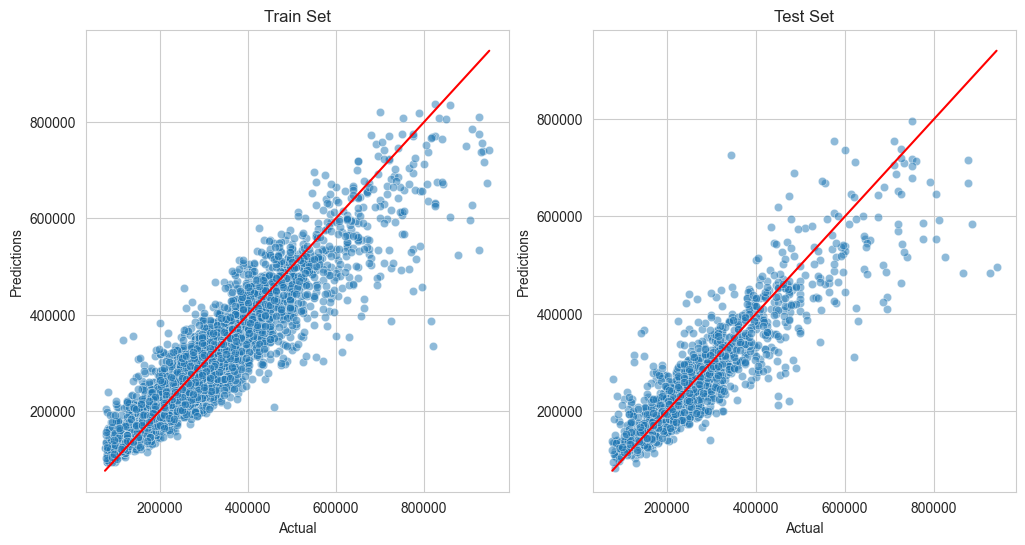

In [99]:
print("Regression Model Performance \nNote the MAE and MSE are in log(GBP) not GBP")
regression_performance(X_train, y_train, X_test, y_test, pipeline)

alpha_scatter=0.5
# change the actuals and predictions to GBP
y_train_gbp = np.expm1(y_train)
y_test_gbp = np.expm1(y_test)
y_pred_gbp = np.expm1(pipeline.predict(X_test))
y_pred_train = np.expm1(pipeline.predict(X_train))

# calculate MAE and MSE should be in GBP not log(GBP) 
mae_train = mean_absolute_error(y_train_gbp, y_pred_train)
print(f"The train set Mean Absolute Error in GBP: {mae_train:,.0f}")

mae_test = mean_absolute_error(y_test_gbp, y_pred_gbp)
print(f"The test  set Mean Absolute Error in GBP: {mae_test:,.0f}")


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.scatterplot(x=y_train_gbp, y=y_pred_train, alpha=alpha_scatter, ax=axes[0])
sns.lineplot(x=y_train_gbp, y=y_train_gbp, color="red", ax=axes[0])
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predictions")
axes[0].set_title("Train Set")

sns.scatterplot(x=y_test_gbp, y=y_pred_gbp, alpha=alpha_scatter, ax=axes[1])
sns.lineplot(x=y_test_gbp, y=y_test_gbp, color="red", ax=axes[1])
axes[1].set_xlabel("Actual")
axes[1].set_ylabel("Predictions")
axes[1].set_title("Test Set")

plt.show()


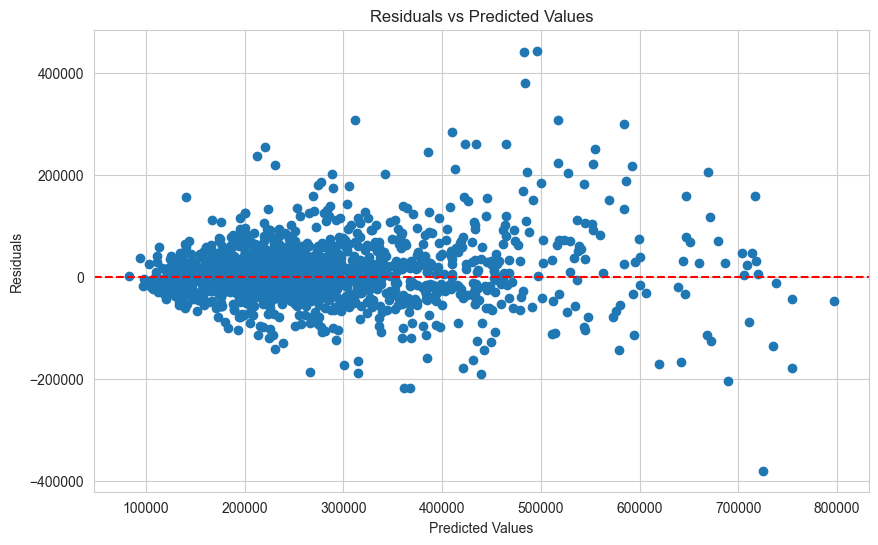

In [100]:
# plot the residuals
residuals = y_test_gbp - y_pred_gbp
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_gbp, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

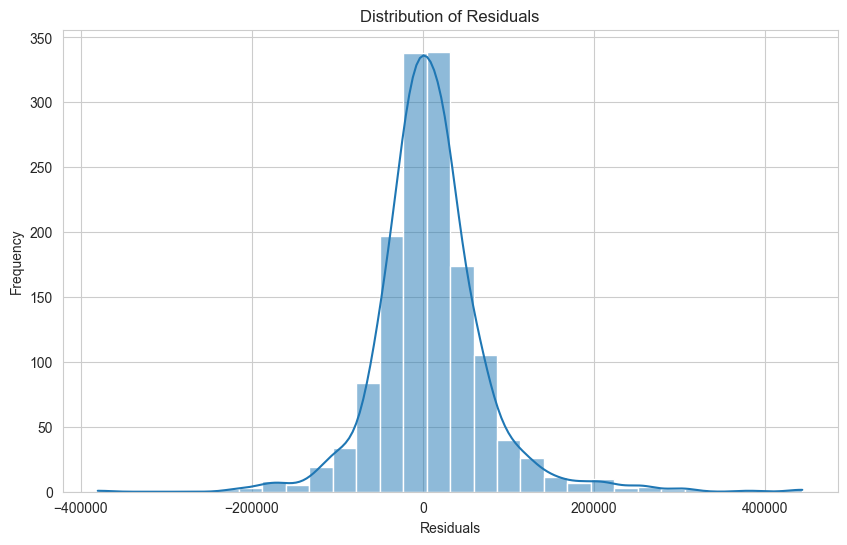

In [101]:
# what is the distribution of the residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

The following analysis uses SHAP (SHapley Additive exPlanations) to explain the output of any machine learning model. https://shap.readthedocs.io/en/latest/ . The code was developed with support by Copilot.

In [102]:
# SHAP values
import shap

In [103]:
# Prepare SHAP explainer using a representative sample
shap.initjs()
rng = np.random.default_rng(101)
sample_size = min(500, len(X_train))
background_idx = rng.choice(len(X_train), size=sample_size, replace=False)
X_background = X_train.iloc[background_idx]
X_background_transformed = pipeline['pre'].transform(X_background)
if hasattr(X_background_transformed, "toarray"):
    X_background_transformed = X_background_transformed.toarray()
explainer = shap.TreeExplainer(pipeline['model'])
test_sample_size = min(500, len(X_test))
test_idx = rng.choice(len(X_test), size=test_sample_size, replace=False)
X_test_sample = X_test.iloc[test_idx]
X_test_transformed = pipeline['pre'].transform(X_test_sample)
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()
shap_values = explainer.shap_values(X_test_transformed)
expected_value = explainer.expected_value
feature_names = get_feature_names_from_preprocessor(pipeline['pre'])

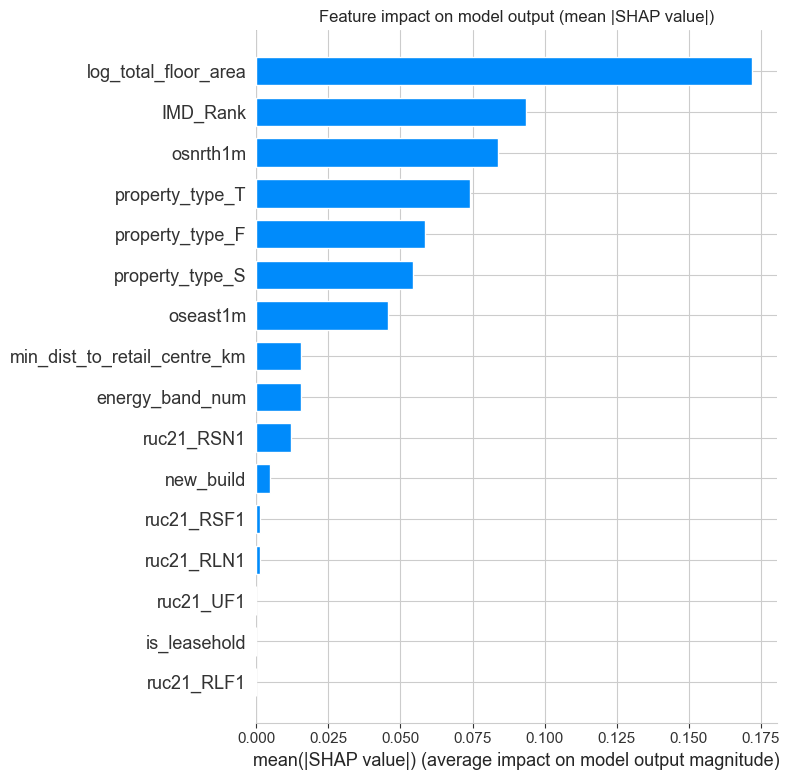

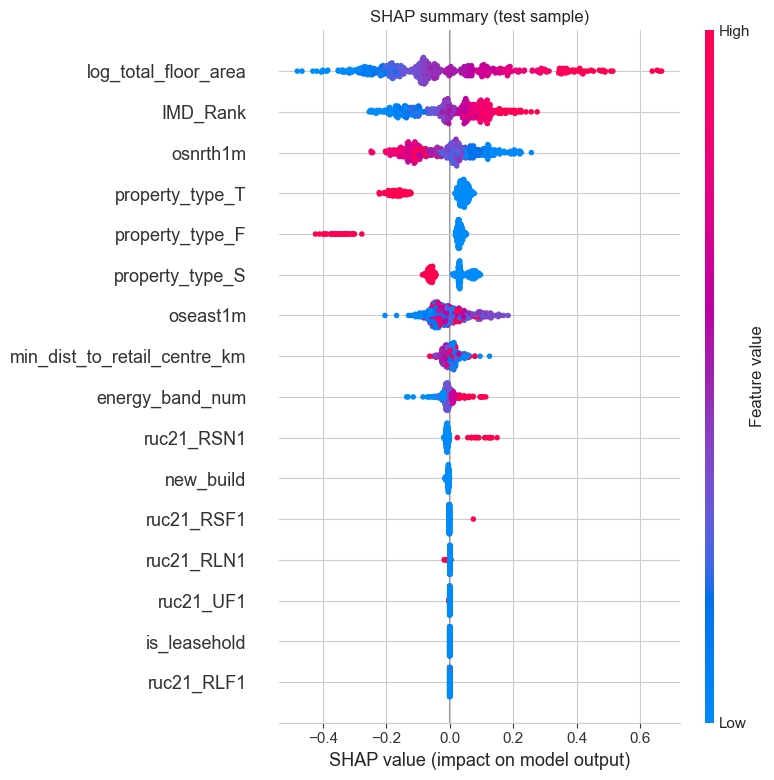

In [104]:
# SHAP plots
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Feature impact on model output (mean |SHAP value|)")
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names, show=False)
plt.title("SHAP summary (test sample)")
plt.tight_layout()
plt.show()

### SHAP chart observations
The SHAP summary plot ranks features by overall impact on predictions. 

_Each dot is one house in the test set. Dot position on the x‑axis is the SHAP value so how much that feature pushed the price up or down relative to the average prediction. Colour encodes the feature value for that point: red is high blue is low._
- How to read magnitudes  
The further dots extend from zero the larger the price effect in log points. 
For example floor area reaches around +0.7 to −0.4 on log price which is roughly +100 percent to −33 percent on an actual price scale.

_See key observations in the conclusions section below.


In [105]:
# Save in a csv for analysis in Tableau
# merge X_train, X_test, y_train_gbp and y_test_gbp into a single dataframe
to_save = pd.concat([X_train, X_test], axis=0)
predicted_price = pd.concat([
    pd.Series(y_pred_train, name="predicted_price"),
    pd.Series(y_pred_gbp, name="predicted_price")
], axis=0)
to_save = pd.concat([
    to_save.reset_index(drop=True), 
    predicted_price.reset_index(drop=True), 
], axis=1)
# rename columns
to_save = to_save.rename(columns={"y_train_gbp": "actual_price_gbp", "y_test_gbp": "actual_price_gbp", "y_pred_train": "predicted_price_gbp", "y_pred_gbp": "predicted_price_gbp"})


In [106]:
# fix the is_leasehold and is_flat columns to be boolean
to_save['is_leasehold'] = to_save['tenure']=='L'
to_save['is_flat'] = to_save['property_type']=='F'
# is_flat_leasehold
to_save['is_flat_leasehold'] = to_save['is_flat'] & to_save['is_leasehold']

# drop columns with all missing values
to_save = to_save.dropna(axis=1, how='all')

# Save the full set for dashboard

In [107]:
to_save.to_csv('../data/processed/XGBRegressor_set.csv', index=False)


In [108]:
import joblib
joblib.dump(value=pipeline , filename="XGBRegressor_model.pkl")

['XGBRegressor_model.pkl']

### Conclusions 

**Summary:**

Model Evaluation 

* Train Set
R2 Score: 0.86
Mean Absolute Error: £34,243

* Test Set
R2 Score: 0.79
Mean Absolute Error: £43,448

- The results show good performance and generalisation of the XGBRegressor model.
- Of the models that generalise, this is the most performant.
  
We used SHAP (SHapley Additive exPlanations) to explain the model.
- The total floor area is dominant (model uses log_total_floor_area). High floor area red points sit at positive SHAP values so larger properties push predicted prices up. Low area blue points sit at negative values so smaller properties pull prices down.  
- IMD_Rank (IMD is the Index of Multiple Deprivation) matters next. Higher rank, less deprived, red pushes price up. Lower rank, more deprived, blue pushes price down.  
- osrnt1m (Northing from Ordnance Survey in meters) Blue dots (lower northing values = more southerly locations) push prices up. Red dots (higher northing values = more northerly locations) push prices down. It is likely that the rail connectivity to London is an underlying factor in that north-south price gradient. 
- Property types (S:Semi-detached, T:Terraced, F:Flat) vs the baseline category are impactful and mostly negative which means being that type lowers price relative to the detached baseline. The impact is ordered by type: Flat > Terraced > Semi-detached.
- oseast1m (Easting) shows a directional effect. Higher values shift predictions up suggesting location along the eastings axis associates with higher prices in this sample.  
- min_dist_to_retail_centre_km is mostly negative for high values red so being farther from retail pulls prices down while being closer blue raises them.  
- The energy efficiency rating, energy_band_num, has a positive effect for higher bands: better efficiency raises prices.  
- Rural urban classification ruc21_RSN1 (Rural town and fringe) area show clear effects. Red points show these settings, such as Solihull (a town in the country), tend to add value.

Size dominates price. Affluence and certain location features raise prices. Non‑detached types reduce price versus detached and the reduction amount is ordered by type: Flat > Terraced > Semi-detached. Energy efficient has a positive effect on prices.


---